# **Fuyu-8B**


In [ ]:
!pip install -q transformers bitsandbytes accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
import time
import cv2
import numpy as np
import torch
from google.colab.patches import cv2_imshow
from urllib.request import Request, urlopen
from transformers import AutoTokenizer, FuyuProcessor, FuyuImageProcessor, FuyuForCausalLM, BitsAndBytesConfig
import pdb

In [ ]:
def url_to_image(url):
  """get image from web url"""
  #definition of User-Agent in header due to website blocking, also see here: https://stackoverflow.com/questions/16627227/problem-http-error-403-in-python-3-web-scraping
  req = Request(url=url, headers={'User-Agent': 'Mozilla/6.0'})
  resp = urlopen(req).read()
  image = np.asarray(bytearray(resp), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  return image

def show(image):
  """show an image in line"""
  cv2_imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

def pprint(text, line_char=88):
  """pretty print text by limit line characters"""
  last_char = "" # handle last word in each line
  for i in range(0, len(text), line_char):
    line = text[i:i+line_char]
    line = last_char+line
    last_char = ""
    line = line.split(" ")
    last_char = line[-1]
    if i <= len(text)-line_char:
      # handle last word in last line
      line = line[:-1]
    print(" ".join(line))

def run_example(prompt, img_url):
  """run example with prompt and image url"""
  # get and show image
  image = url_to_image(img_url)
  show(image)
  # run the model
  output = fuyu.prompt(prompt, image, out_tokens=100)
  # pretty print example info
  pprint(f"\nGiven \x1b[1;31mimage\x1b[0m \x1B[3m{img_url}\x1B[0m \x1b[1;31mand\x1b[0m the following \x1b[1;31mprompt\x1b[0m:\n\n\x1B[3m{prompt}\x1B[0m", 80)
  pprint(f"The \x1b[1;31mmodels output\x1b[0m:\n\n\x1B[3m{output}\x1B[0m\n", 88)



In [ ]:
class Fuyu():
    """Pretrained fuyu model of Adept via huggingface"""

    def __init__(self, model_id="ybelkada/fuyu-8b-sharded"):
        # check if GPU can be used
        if torch.cuda.is_available():
            print("You are running the model on GPU.")
            self.device = torch.device("cuda")
            self.dtype = torch.float16
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=self.dtype
            )
            self.model = FuyuForCausalLM.from_pretrained(model_id, quantization_config=quantization_config)
        else:
            print("You are running the model on CPU, the runtime might be very slow. 🐌")
            self.device = torch.device("cpu")
            self.dtype = torch.bfloat16
            # 4bit quantization is currently not working with the latest version of transformers (as of today: 4.35.0.dev0), it is working with transformers 4.30, however fuyu is not integrated there.
            self.model = FuyuForCausalLM.from_pretrained(model_id, device_map=self.device, torch_dtype=self.dtype)

        # initialize tokenizer and fuyu processor, pretrained and via huggingface
        self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        self.processor = FuyuProcessor(image_processor=FuyuImageProcessor(), tokenizer=self.tokenizer)

    def prompt(self, text, image=None, out_tokens=50):
        """Prompt the model with a text and optional an image prompt."""

        if image is None:
            # if no image is provided, use a small black image
            # Warning: This is working but the model is not trained on this image fake. Test purpose only!
            image = np.zeros((30,30,3), dtype=np.uint8)

        # pre processing image and text
        inputs = self.processor(text=text, images=[image], return_tensors="pt").to(self.device)
        prompt_len = inputs["input_ids"].shape[-1]

        # process
        t0 = time.time()
        generation_output = self.model.generate(**inputs, max_new_tokens=out_tokens, pad_token_id=self.tokenizer.eos_token_id)
        print(f"\nGeneration time: {time.time()-t0:.0f}s")

        # post processing
        generation_text = self.tokenizer.decode(generation_output[0][prompt_len:], skip_special_tokens=True)
        return generation_text.lstrip()

In [ ]:
model_id = "ybelkada/fuyu-8b-sharded"
fuyu = Fuyu(model_id)

You are running the model on GPU.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/60.5k [00:00<?, ?B/s]

model-00001-of-00011.safetensors:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

model-00002-of-00011.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

model-00003-of-00011.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

model-00004-of-00011.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00005-of-00011.safetensors:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

model-00006-of-00011.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

model-00007-of-00011.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

model-00008-of-00011.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00009-of-00011.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model-00010-of-00011.safetensors:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

model-00011-of-00011.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/11 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/848 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/6.13M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

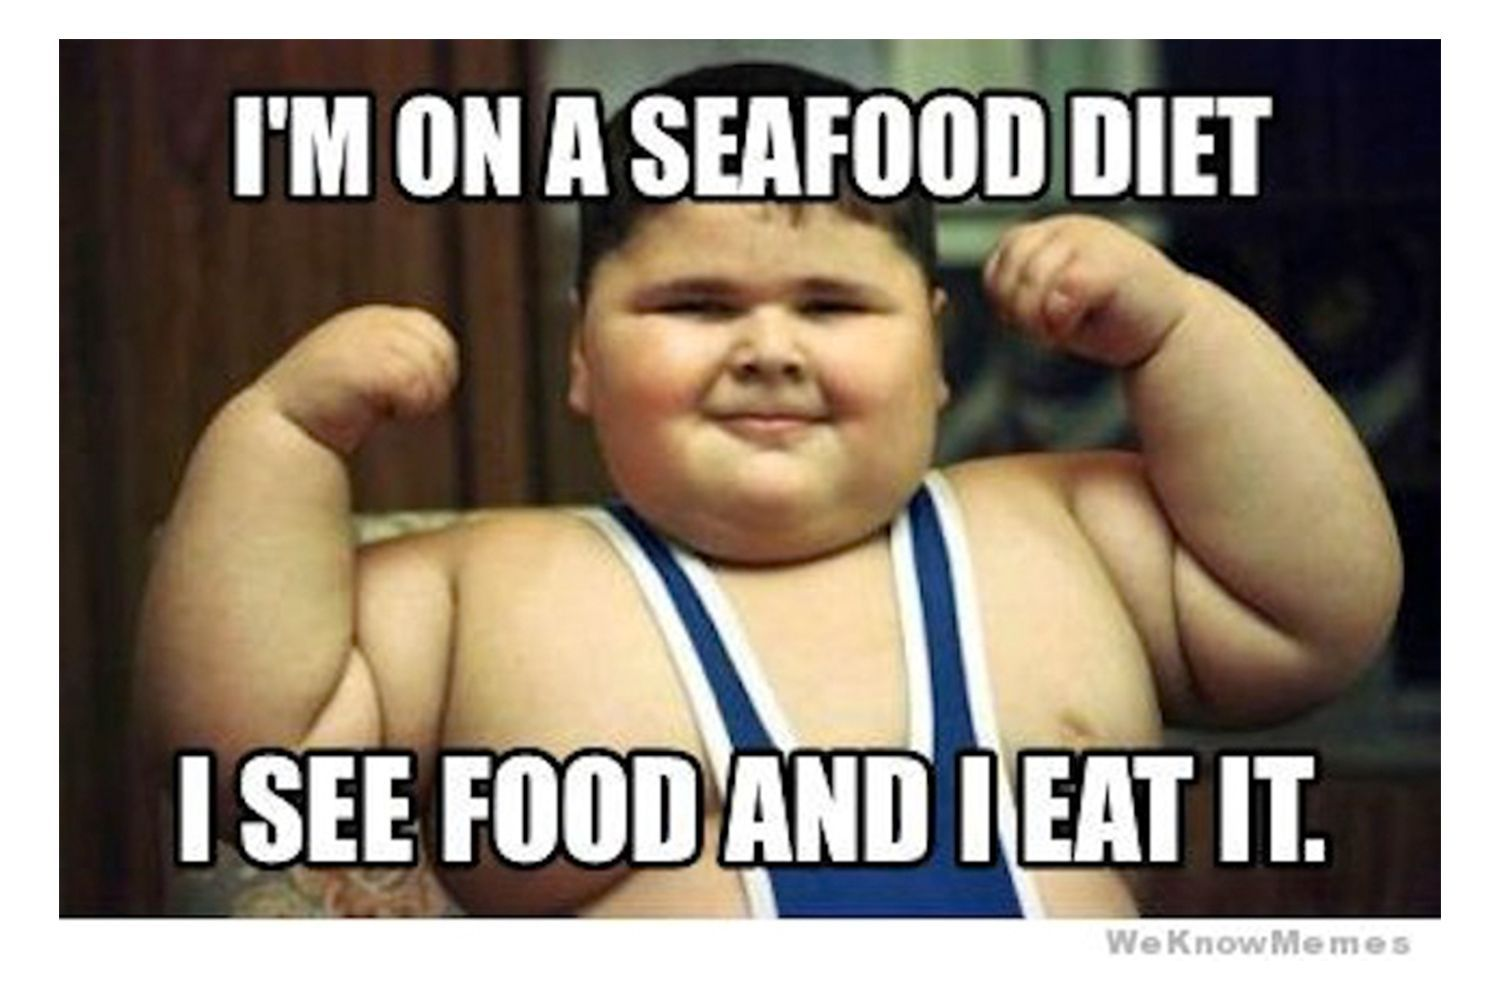


Generation time: 6s
of a boy flexing his muscles with text at the bottom that reads "I'm on a seafood diet"


In [ ]:
prompt= "What is written in the image"        #@param {type:"string"}
image_url = "https://img.delicious.com.au/WqbvXLhs/del/2016/06/more-the-merrier-31380-2.jpg"        #@param {type:"string"}
out_tokens = 48           #@param {type:"slider", min:0, max:100, step:1}

# show image
image = url_to_image(image_url)
show(image)

# run model
output = fuyu.prompt(prompt, image, out_tokens=out_tokens)
pprint(output)

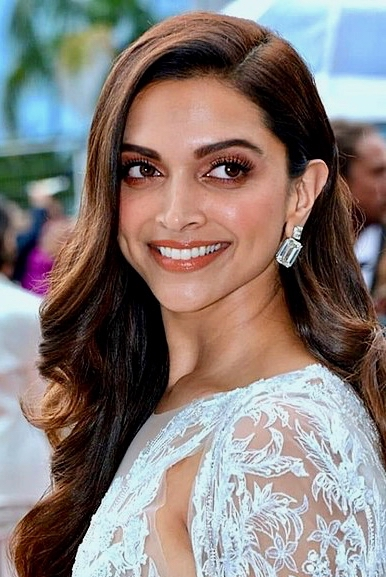


Generation time: 4s
The image features a beautiful woman smiling at the camera, wearing earrings and a
white dress. The celebrity is smiling and posing for a picture, likely at a special event or
gathering.



In [ ]:
prompt= "Describe this image and who is this celebrity"        #@param {type:"string"}
image_url = "https://upload.wikimedia.org/wikipedia/commons/b/b6/Deepika_Padukone_Cannes_2018_(cropped).jpg"
out_tokens = 100          #@param {type:"slider", min:0, max:100, step:1}

# show image
image = url_to_image(image_url)
show(image)

# run model
output = fuyu.prompt(prompt, image, out_tokens=out_tokens)
pprint(output)

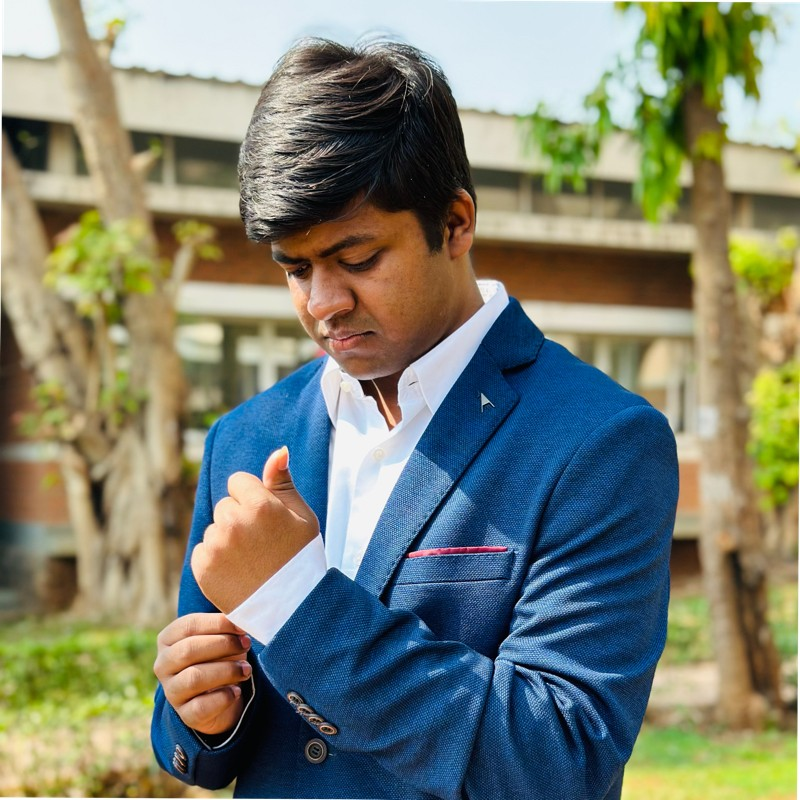


Generation time: 7s
A man in a blue suit is standing outdoors, looking down at his shirt collar. He is
wearing a tie, which adds to his formal appearance. The man is wearing a white shirt
underneath his blue suit, which complements his outfit.

In the background, there is a building
visible, and trees are scattered throughout the scene. Additionally, there is a person
standing further back, possibly observing the man in the suit.


In [ ]:
prompt= "Describe this image"        #@param {type:"string"}
image_url = "https://media.licdn.com/dms/image/D4D03AQFmR23P6_EmzQ/profile-displayphoto-shrink_800_800/0/1674661693718?e=2147483647&v=beta&t=KDUAdNganDRpajuCOkNb8WhduSq0JaJA23tKgbfhUs4"
out_tokens = 100         #@param {type:"slider", min:0, max:100, step:1}

# show image
image = url_to_image(image_url)
show(image)

# run model
output = fuyu.prompt(prompt, image, out_tokens=out_tokens)
pprint(output)

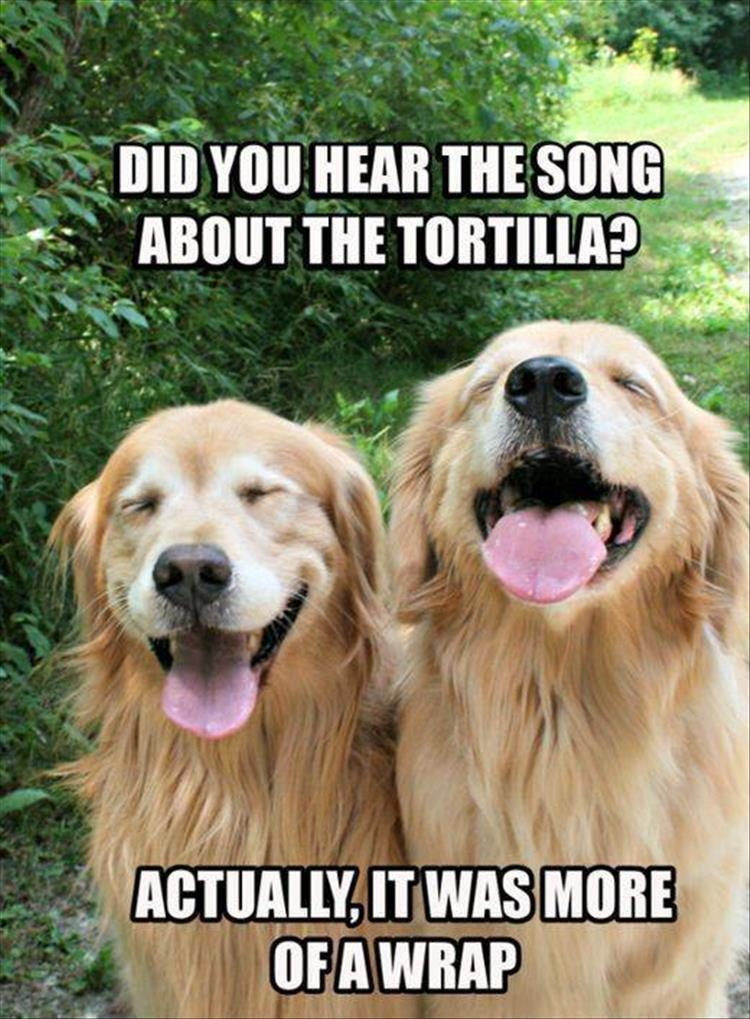


Generation time: 7s
In the image, two golden-colored dogs are standing next to each other in a grassy
field. One of the dogs is panting, showing its tongue, while the other dog is smiling. The
scene is captioned with the words " Did you hear the song about a tortilla? It was more of
a wrap." This caption is accompanied by a black box with white letters, which adds to
the humorous theme of the image.


In [ ]:
prompt= "Describe this image and specify what is written in it"        #@param {type:"string"}
image_url = "https://amazinganimalphotos.com/wp-content/uploads/2019/01/funny-animal-memes-with-captions-11.jpg"
out_tokens = 100         #@param {type:"slider", min:0, max:100, step:1}

# show image
image = url_to_image(image_url)
show(image)

# run model
output = fuyu.prompt(prompt, image, out_tokens=out_tokens)
pprint(output)